the length of time a customer remains on a subscription is a key metric for us to
understand how well we’re serving our customers -- if they stay subscribed for a long time, we
know that we’re providing them value.

Of particular interest is how subscription switching behavior is related to
customer retention. In particular, are customers who switch their subscription product more
likely to stay subscribed for longer? Does that vary based on which products they’re switching
from and to?

- `ID` - the id of the subscription, uniquely identifies rows 
- `viewable_product_id` - the identifier of the product the customer is subscribed to
- `created_at` - the timestamp indicating when the subscription started 
- `quantity` - the number of items sybscriped to (eg a customer could have one subscription to two foaming shave gels) 
- `user_id` - uniquely identifies a single customer and will appear multiple times for customers with multiple subscriptions 
- `removed_at` - timestamp indicating when that subscription ended. The column will be blank for subscriptions that havent eneded 
- `created_by_client_type` - was this subscription created by the customer on the web or by a customer experience associate via admin 
- `removed_by_client_type` - was this subscription remvoed by the customer on the web or by a customer experience associate via admin 

- a customer is considered retained untill all of their subscriptions are ended 
- if, for one customer, you see a particular subscription end and a new subscritopn stat at the same time, thats considered a switch 
- customers can also add additional products to their subscrition 

In [1]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

#pandas - DataFrames to organize our data
import pandas as pd 
#numpy - linear algebra and matrices for python
import numpy as np  
#matplotlib - workhorse plotting library
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = 8,6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
#seaborn - easy plotting for statistical visualizations, based on plt
import seaborn as sns
import re 

In [2]:
# Suppress all warnings just to keep the notebook nice and clean. 
# This must happen after all imports since numpy actually adds its
# RankWarning class back in.
import warnings
warnings.filterwarnings("ignore")

In [3]:
# data path
datapath1 = "harrys.xlsx"

In [4]:
# load the excel data into a dataframe
data1 = pd.read_excel(datapath1)

In [5]:
# get info on the data
print('Dataframe dimensions:', data1.shape)
tab_info=pd.DataFrame(data1.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data1.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(data1.isnull().sum()/data1.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(data1[:2])

Dataframe dimensions: (9967, 8)


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
column type,int64,int64,datetime64[ns],int64,int64,datetime64[ns],object,object
null values (nb),0,0,0,0,0,6372,0,6449
null values (%),0,0,0,0,0,63.931,0,64.7035


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN


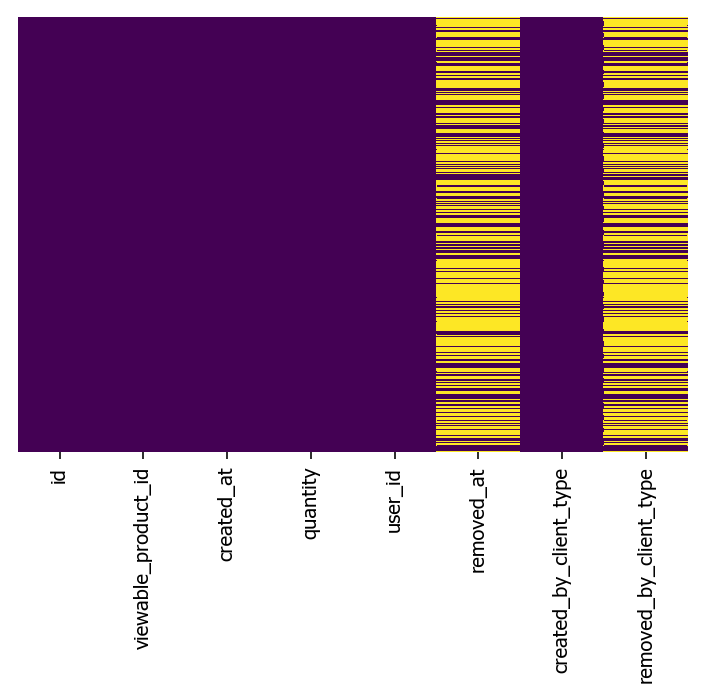

In [6]:
# check for null values visually 
sns.heatmap(data1.isnull(), yticklabels=False, cbar=False, cmap='viridis') 
plt.show()

In [7]:
data1.columns

Index(['id', 'viewable_product_id', 'created_at', 'quantity', 'user_id',
       'removed_at', 'created_by_client_type', 'removed_by_client_type'],
      dtype='object')

In [8]:
data1.nunique()

id                        9967
viewable_product_id         18
created_at                9967
quantity                     4
user_id                   7702
removed_at                3590
created_by_client_type       4
removed_by_client_type       3
dtype: int64

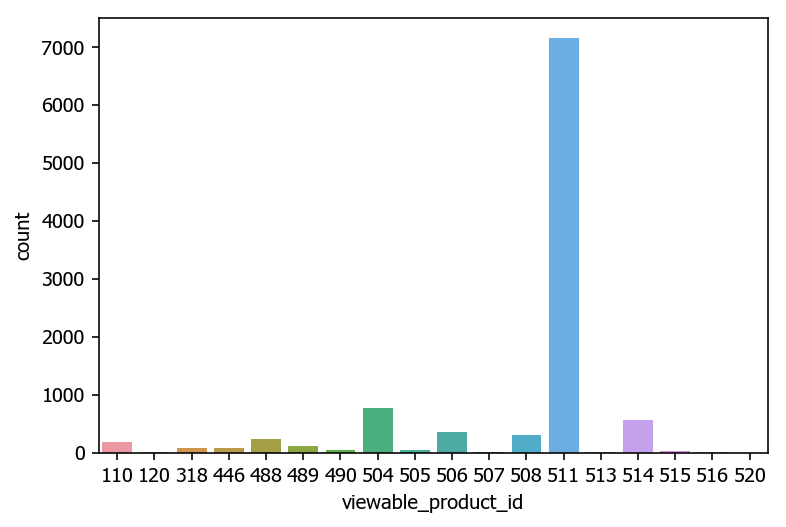

In [9]:
sns.countplot(x=data1["viewable_product_id"],data=data1)
plt.show()

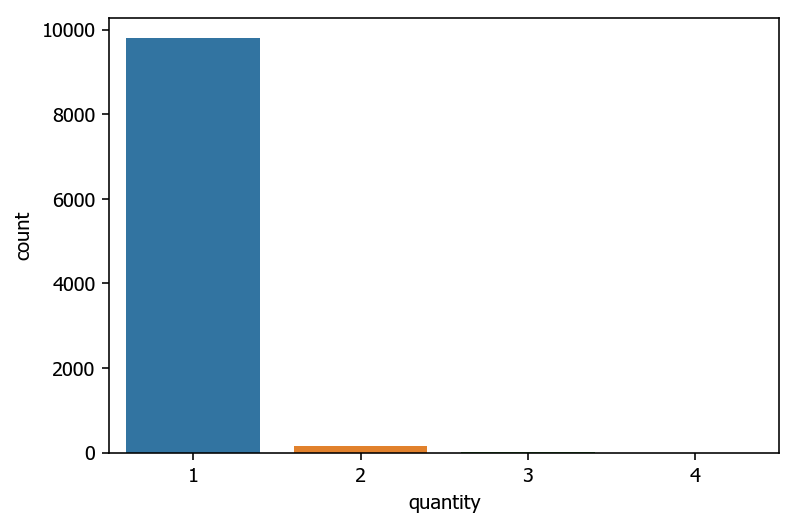

In [10]:
sns.countplot(x=data1["quantity"],data=data1)
plt.show()

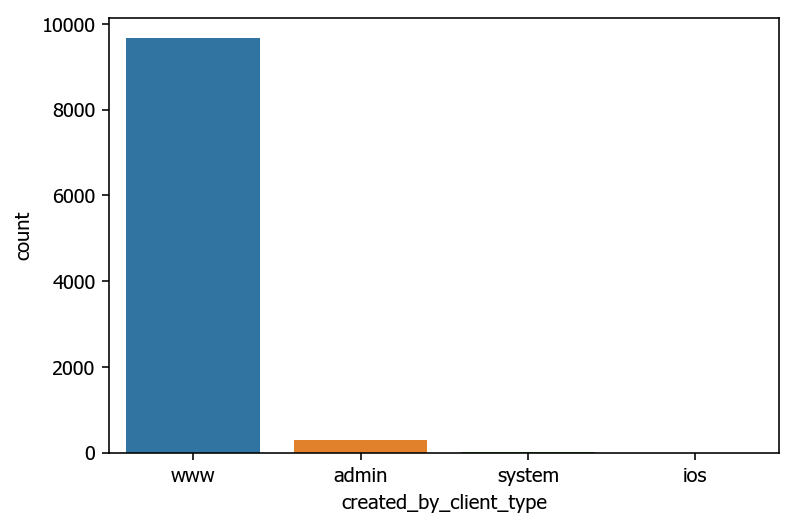

In [11]:
sns.countplot(x=data1["created_by_client_type"],data=data1)
plt.show()

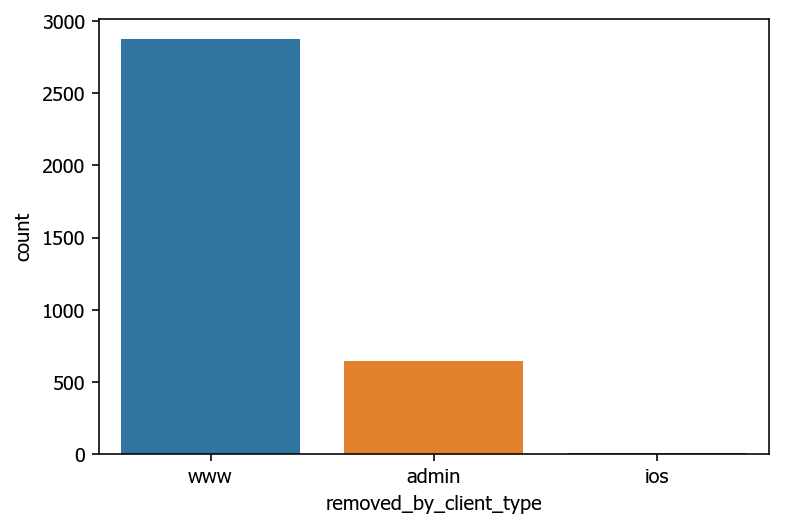

In [12]:
sns.countplot(x=data1["removed_by_client_type"],data=data1)
plt.show()

In [13]:
# find the number of unique users 

data1.user_id.nunique()

7702

In [14]:
# find the time period of customer subscriptions 
# first import datetime libraries 
import datetime 
from dateutil import parser 

In [15]:
# find the time period of customer subscriptions 
print("Earliest Date:",data1.created_at.min(), "\n", "Latest Date:",data1.created_at.max(), "\n",  \
"Number of days in between them:", data1.created_at.max() - data1.created_at.min())

Earliest Date: 2016-07-22 00:02:21.127000 
 Latest Date: 2017-02-01 22:54:52.268000 
 Number of days in between them: 194 days 22:52:31.141000


We are working with 7702 customers who made subscriptions over an approximatly seven month period of time. Since we are interested in the behavior of customers who made more than one subsciprtion, it makes sense to first break up the customer cohort into two groups: those that have more than one `id` associated with them (and thus, more than one subscription), and those that have only one `id` associated with them (and thus made only one subscription). From there, we can zoom in further and look at those who canceled and who remained active and perform time series analysis to answer our original question of interest. 

In [16]:
# lets look at the df and find a way to index and segment to achieve this 
data1.head()

,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN
2,1539095,511,2016-08-10 20:02:59.016,1,52992,2016-12-05 21:31:19.158,www,www
3,1515988,511,2016-08-04 12:47:41.972,1,65654,2016-09-12 11:20:09.225,www,www
4,1495173,511,2016-07-28 19:49:50.478,1,95304,NaT,www,NaN


In [17]:
# verify that id is unique for each row, there should be 9967 unique transactions if it is
data1.id.nunique()

9967

In [25]:
# Creates table with each customer having a row for each unique subscription id
cust_sub_table = data1.drop_duplicates(['user_id', 'id'])[['user_id', 'id']]

# Get number of subscriptions per customer
cust_sub_count = cust_sub_table.groupby(['user_id']).count().reset_index()

# Get customers with only one subscription
one_sub_cust = cust_sub_count.query('id == 1')

In [32]:
cust_sub_count.head()

,user_id,id
0,968,1
1,5404,1
2,7938,1
3,17951,5
4,19323,2


In [33]:
one_sub_cust.head()

,user_id,id
0,968,1
1,5404,1
2,7938,1
5,19468,1
6,20407,1


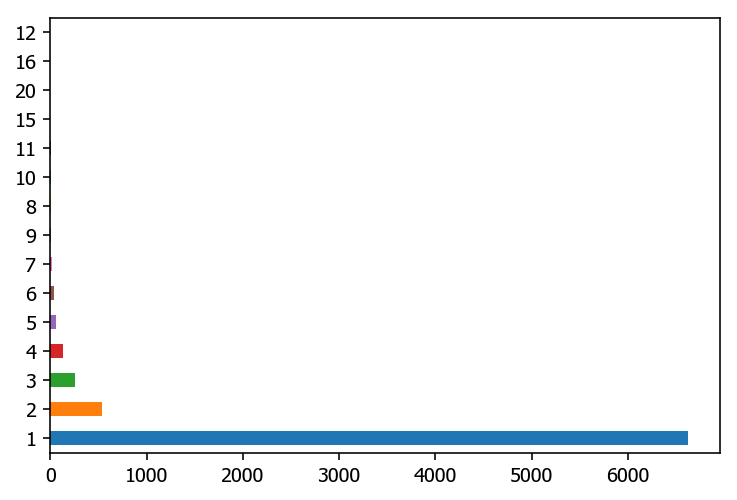

In [30]:
cust_sub_count.id.value_counts().plot(kind='barh')

In [31]:
cust_sub_count.id.value_counts()

1     6627
2      541
3      258
4      133
5       55
6       39
7       15
9       11
8        9
10       6
11       4
15       1
20       1
16       1
12       1
Name: id, dtype: int64

In [36]:
# create excels 
cust_sub_count.to_excel("cust_sub_count.xlsx")

In [38]:
one_sub_cust.to_excel("one_sub_cust.xlsx")

In [39]:
# data path
datapath2 = "harrys_updated.xlsx"

In [40]:
# load the excel data into a dataframe
data2 = pd.read_excel(datapath2)

In [41]:
# get info on the data
print('Dataframe dimensions:', data2.shape)
tab_info=pd.DataFrame(data2.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(data2.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(data2.isnull().sum()/data2.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
display(data2[:2])

Dataframe dimensions: (9967, 9)


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type,cust_sub_count
column type,int64,int64,datetime64[ns],int64,int64,datetime64[ns],object,object,int64
null values (nb),0,0,0,0,0,6372,0,6449,0
null values (%),0,0,0,0,0,63.931,0,64.7035,0


,id,viewable_product_id,created_at,quantity,user_id,removed_at,created_by_client_type,removed_by_client_type,cust_sub_count
0,1493735,511,2016-07-28 12:34:42.906,1,36867,NaT,www,NaN,1
1,1607724,490,2016-08-28 19:00:06.840,1,42060,NaT,www,NaN,1
